In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [2]:
annotation_file = 'annotations/captions_train2014.json' #'/datasets/mscoco/annotations/captions_train2014.json' #'annotations/captions_train2014.json' 
PATH = './train2014/' #'/datasets/mscoco/train2014/' # 'train2014'

In [3]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [4]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [5]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [6]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

In [7]:
assert len(train_captions) == len(img_name_vector)

<start> A tall pole with a street sign on it containing drawings of two sad faces <end>


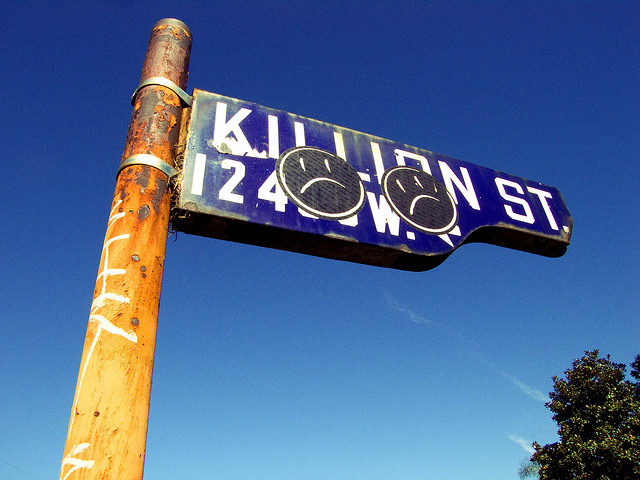

In [8]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Preprocess Image

In [9]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## InceptionV3 (2019) as an Encoder

In [10]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [11]:
from tqdm import tqdm

In [23]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

  0%|          | 0/375 [00:00<?, ?it/s]


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv2D]

In [14]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [15]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [16]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

## Split the data into training and testing

In [17]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [18]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24009, 24009, 6002, 6002)

## Create a tf.data dataset for training

In [19]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [20]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [21]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# # Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE) # Batch_size * (img_name_train, cap_train)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
for train, caption in dataset.take(1):
    print(caption)

UnknownError: FileNotFoundError: [Errno 2] No such file or directory: './train2014/COCO_train2014_000000562648.jpg.npy'
Traceback (most recent call last):

  File "//home/jaahn/.local/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "//home/jaahn/.local/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "<ipython-input-20-f8ebf6c66200>", line 3, in map_func
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')

  File "//home/jaahn/.local/lib/python3.8/site-packages/numpy/lib/npyio.py", line 416, in load
    fid = stack.enter_context(open(os_fspath(file), "rb"))

FileNotFoundError: [Errno 2] No such file or directory: './train2014/COCO_train2014_000000562648.jpg.npy'


	 [[{{node PyFunc}}]] [Op:IteratorGetNext]

## Model

In [35]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [36]:
from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import RandomUniform

class SpatialGatingUnit(Layer):
    def __init__(self, init_ept):
        super().__init__()
        self.norm_layer = tf.keras.layers.LayerNormalization(axis=-1)
        self.initializer = RandomUniform(minval=-init_ept, maxval=init_ept)
        
    def call(self, x, tiny_attn=None):
        u,v = tf.split(x, num_or_size_splits=2, axis=-1)
        v = self.norm_layer(v)
        
        n = v.shape[-2]
        dense_layer = tf.keras.layers.Dense(n, kernel_initializer=self.initializer, bias_initializer='ones')
        v = tf.linalg.matrix_transpose(v)
        v = dense_layer(v)
        v = tf.linalg.matrix_transpose(v)
        
        if tiny_attn:
            v = v + tiny_attn
        
        return u * v

In [ ]:
# TODO: change this to masked attention!
class Attention(Layer):
    def __init__(self, d_out, d_attn=None):
        self.d_attn = d_attn
        
        self.proj_in = tf.keras.layers.Dense(3 * d_attn)
        self.proj_out = tf.keras.layers.Dense(d_out)
    
    def call(self, x):
        qkv = self.proj_in(x)
        q, k, v = tf.split(qkv, num_or_size_splits=3, axis=-1)
        w = tf.einsum('bid,bjd->bij', q, k)
        a = tf.nn.softmax(w * tf.math.rsqrt(self.d_attn))
        x = tf.einsum('bij,bjd->bid', a, v)
        return self.proj_out(x)
        

In [37]:
# init_ept = 1e-3
class GMLP_Block(tf.keras.Model):
    def __init__(self, d_ffn, d_model, init_ept, attn_dim=None):
        super().__init__()
        
        self.norm_layer = tf.keras.layers.LayerNormalization(axis=-1)
        
        # attention
        self.tiny_attn = Attention(d_ffn // 2, attn_dim) if attn_dim else None
        
        self.proj_in = tf.keras.layers.Dense(d_ffn, activation='gelu')
        self.proj_out = tf.keras.layers.Dense(d_model)
        self.sgu = SpatialGatingUnit(init_ept)
        
    def call(self, x):
        shortcut = x
        
        x = self.norm_layer(x)
        attn = self.tiny_attn(x)

        x = self.proj_in(x)
        x = self.sgu(x, attn)
        x = self.proj_out(x)
        return x + shortcut 

In [38]:
# positional encoding
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [39]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [46]:
class NLPgMLP(tf.keras.Model):
    def __init__(self, num_layers, embedding_dim, vocab_size, maximum_position_encoding, init_ept, attn_dim=None):
        super().__init__()
        
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # positional encoding
        self.pos_encoding = positional_encoding(maximum_position_encoding, embedding_dim)
        
        self.gmlp = [GMLP_Block(4 * embedding_dim, embedding_dim, init_ept, attn_dim) for _ in range(num_layers)]
        self.last_dense = tf.keras.layers.Dense(vocab_size)
        self.to_logits = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dense(vocab_size)
        ])
        
    def call(self, x, features):
        seq_len = tf.shape(x)[1]
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        y = tf.concat([features, x], axis=1)
        
        for i in range(self.num_layers):
            y = self.gmlp[i](y)
        y = self.to_logits(y)
        
        return y

In [49]:
init_ept = 1e-3
num_layers = 1
attn_dim = 64
vocab_size = tokenizer.vocabulary_size()

encoder = CNN_Encoder(embedding_dim)
decoder = NLPgMLP(num_layers, embedding_dim, vocab_size, 6000, init_ept, attn_dim)

In [50]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [51]:
learning_rate = CustomSchedule(embedding_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [52]:
tf.math.logical_not(tf.math.equal([1,2,0], 0))

<tf.Tensor: shape=(3,), dtype=bool, numpy=array([ True,  True, False])>

In [53]:
for i in cap_vector.take(1):
    print(i)

tf.Tensor(
[  3   2  56 282 371  61 189  28   2  79   4   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(50,), dtype=int64)


## Checkpoint

In [56]:
# gmlp_train (vanila gmlp), gmlp_attn_train (gmlp + self_attention)
checkpoint_path = "./checkpoints/gmlp_attn_train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [55]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    print(ckpt_manager.latest_checkpoint)
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

./checkpoints/train/ckpt-4


## Training

- Teacher forcing technique

In [58]:
def train_step(img_tensor, target):
    # target shape: batch_size * seq_len
    loss = 0
    
    dec_input = tf.expand_dims([word_to_index(tf.constant('<start>'))] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        
        for i in range(1, target.shape[1]):
            predictions = decoder(dec_input, features)
            
            loss += loss_function(target[:, i], predictions)
            
            # using teacher forcing # TODO: change this to pass all previous, not just current!
            dec_input = tf.expand_dims(target[:, i], 1)
            
    total_loss = (loss / int(target.shape[1]))
    
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [59]:
loss_plot = []
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')

    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 5 Batch 0 Loss 1.6481
Epoch 5 Batch 100 Loss 0.9189
Epoch 5 Batch 200 Loss 0.8554
Epoch 5 Batch 300 Loss 0.8248
Epoch 5 Loss 0.932151
Time taken for 1 epoch 243.57 sec

Epoch 6 Batch 0 Loss 0.7811
Epoch 6 Batch 100 Loss 0.6933
Epoch 6 Batch 200 Loss 0.6585
Epoch 6 Batch 300 Loss 0.6062
Epoch 6 Loss 0.673137
Time taken for 1 epoch 230.84 sec

Epoch 7 Batch 0 Loss 0.6172
Epoch 7 Batch 100 Loss 0.5685
Epoch 7 Batch 200 Loss 0.5908
Epoch 7 Batch 300 Loss 0.5524
Epoch 7 Loss 0.558685
Time taken for 1 epoch 223.58 sec

Epoch 8 Batch 0 Loss 0.5111
Epoch 8 Batch 100 Loss 0.4896
Epoch 8 Batch 200 Loss 0.5307
Epoch 8 Batch 300 Loss 0.4865
Epoch 8 Loss 0.497367
Time taken for 1 epoch 225.93 sec

Epoch 9 Batch 0 Loss 0.4638
Epoch 9 Batch 100 Loss 0.4596
Epoch 9 Batch 200 Loss 0.4834
Epoch 9 Batch 300 Loss 0.4690
Epoch 9 Loss 0.460022
Time taken for 1 epoch 228.29 sec

Epoch 10 Batch 0 Loss 0.4608
Epoch 10 Batch 100 Loss 0.4357
Epoch 10 Batch 200 Loss 0.4034
Epoch 10 Batch 300 Loss 0.4334
Epo

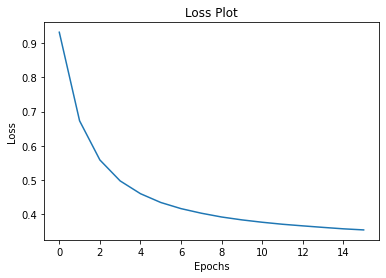

In [60]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

In [61]:
def evaluate(image):
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index(tf.constant('<start>'))], 0)
    result = []

    for i in range(max_length):
        predictions = decoder(dec_input, features)

#         attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = index_to_word(tf.constant(predicted_id)).numpy().decode('utf-8')
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

#     attention_plot = attention_plot[:len(result), :]
    return result

Real Caption: <start> a close up picture of a cooked pizza. <end>
Prediction Caption: a large pizza has a [UNK] with a [UNK] is a pizza sitting on a large slice up with a [UNK] <end>


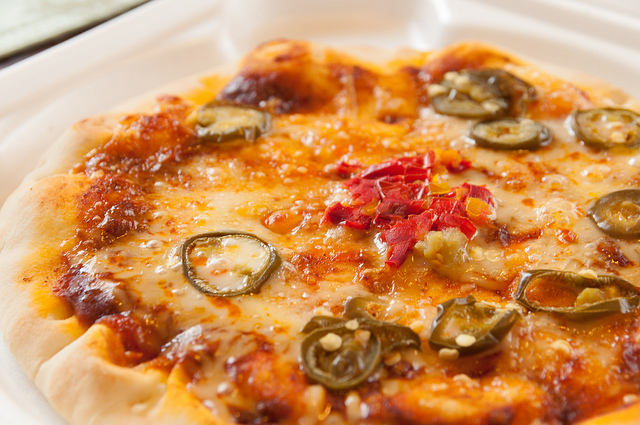

In [67]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
Image.open(image)

## With my own image

Prediction Caption: a surfboard riding the group of a surfboard riding a surfboard riding a wave. <end>


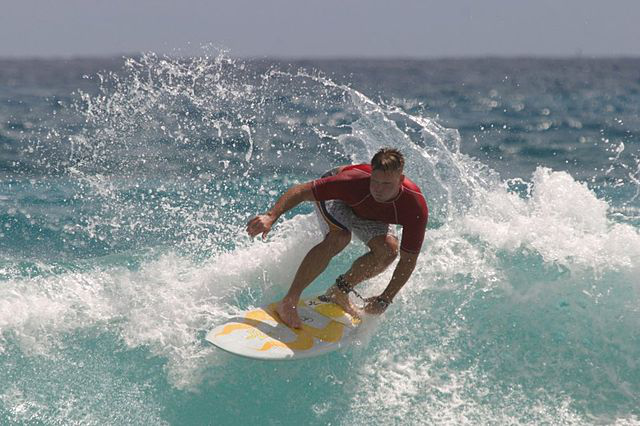

In [70]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
# opening the image
Image.open(image_path)